In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

import lightning as L
from torch.utils.data import Dataset,DataLoader
# 14h30

# Résolution de l'équation de Helmholtz non homogène avec un Physics Informed Neural Network (PINN)

Dans ce TP, nous allons explorer la résolution de l'équation de Helmholtz non homogène en utilisant PINN. L'équation de Helmholtz est une équation différentielle partielle linéaire qui joue un rôle crucial dans divers domaines de la physique, tels que l'acoustique, l'électromagnétisme et la mécanique quantique.

L'équation de Helmholtz non homogène est donnée par :

$$\Large \nabla^2 u + k^2 u = f$$

où :
- $\nabla^2$ est l'opérateur laplacien,
- $u$ est la fonction inconnue que nous cherchons à déterminer,
- $k$ est une constante souvent liée à la fréquence ou à l'énergie,
- $f$ est le terme source.

Dans ce TP, nous considérons un terme source spécifique défini par :

$$\Large f = (-(a_1\pi)^2 - (a_2\pi)^2 + k^2) \sin(a_1\pi x) \sin(a_2\pi y)$$

Nous utilisons les conditions limites de Dirichlet avec une valeur 0 aux limites du domaine. On prendra $k=1$, $a1=2$ et $a2=1$.

In [3]:
# PDE configurations
a1 = 2
a2 = 1
k  = 1

# Création de la base de test

L'équation de Helmholtz non homogène a pour solution $$\Large u = sin(a_1\pi x) sin(a_2\pi y)$$

Définissez un *dataset* pytorch de test correspondant aux valeurs de la fonction $u$ solution pour une grille de point régulière avec $x\in[-1,1]$ et $y\in[-1,1]$.

Visulalisez ces points.

In [4]:
class DatasetTest(Dataset):
    def __init__(self,
                 num_test_x =  120,
                 num_test_y =  120,
                 bounds = [-1,1,-1,1] # x min, x max, y min, y max
                ):
        self.num_test_x = num_test_x
        self.num_test_y = num_test_y
        self.bounds = bounds

    def __len__(self):
        return self.num_test_x * self.num_test_y

    def __getitem__(self, idx):
        x = (idx // self.num_test_y)*(self.bounds[1] - self.bounds[0])/self.num_test_x + self.bounds[0]
        y = (idx  % self.num_test_y)*(self.bounds[3] - self.bounds[2])/self.num_test_y + self.bounds[2]
        u = np.sin(a1 * np.pi * x) * np.sin(a2 * np.pi * y)
        return torch.Tensor([x,y]),torch.Tensor([u])

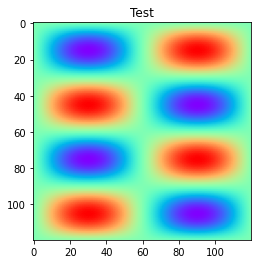

In [5]:
# Valdidation des datasets
test = DatasetTest(120,120)
test_loader = DataLoader(test, batch_size=len(test))

X,y= next(iter(test_loader))
plt.imshow(y.reshape((120,120)),cmap='rainbow')
plt.title('Test')
plt.show()

# PINN avec Pytorch

## Definition du domain

Définissez un ensemble d'apprentissage comportant 1024 points de collocation non supervisé et 1024 points sur les bords associé à la valeur 0.

In [6]:
class DatasetTrain(Dataset):
    def __init__(self,
                 nbCollocation =  1024,
                 nbBounds =  1024,
                 bounds = [-1,1,-1,1] # x min, x max, y min, y max
                ):
        self.nbCollocation = nbCollocation
        self.nbBounds = nbBounds
        self.bounds = bounds
        
        # Points intérieurs
        self.p_collocation = torch.rand(nbCollocation,2)
        self.p_collocation[:,0] = self.p_collocation[:,0]*(bounds[1]-bounds[0])+bounds[0]
        self.p_collocation[:,1] = self.p_collocation[:,1]*(bounds[3]-bounds[2])+bounds[2]

        # définition des coins du carré
        coin = torch.Tensor([[bounds[0],bounds[2]],
                      [bounds[0],bounds[3]],
                      [bounds[1],bounds[2]],
                      [bounds[0],bounds[2]]
                    ])
        # définition des directions de translations
        v = torch.Tensor([
            [0,bounds[3]-bounds[2]],
            [bounds[1]-bounds[0],0],
            [0,bounds[3]-bounds[2]],
            [bounds[1]-bounds[0],0]
        ])
        # points sur les bords
        self.p_bounds = (coin[None]+v[None]*torch.rand(nbBounds,1,1)).reshape(-1,2)

    def __len__(self):
        return self.nbCollocation + self.nbBounds

    def __getitem__(self, idx):
        if idx<self.nbCollocation:
            return self.p_collocation[idx] , 1, torch.Tensor([0]) # 1 pour intérieur, 0 valeur du residu
        return self.p_bounds[idx-self.nbCollocation]  ,0 , torch.Tensor([0]) # 0 pour bordure, 0 valeur de bord


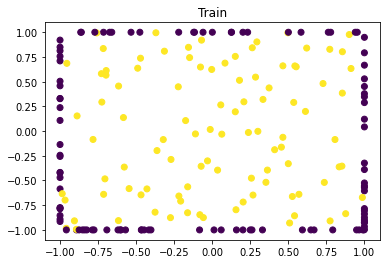

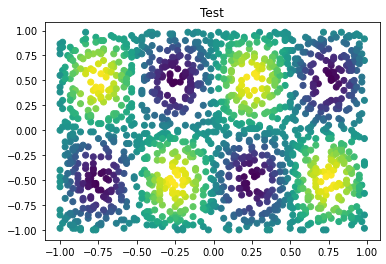

In [7]:
# Valdidation des datasets
train = DatasetTrain()
train_loader = DataLoader(train,shuffle=True, batch_size=len(train)//10)
test = DatasetTest()
test_loader = DataLoader(test,shuffle=True, batch_size=len(test)//10)

X,type_p,y= next(iter(train_loader))
plt.scatter(X[:,0],X[:,1],c=type_p)
plt.title('Train')
plt.show()

X,y= next(iter(test_loader))
plt.scatter(X[:,0],X[:,1],c=y)
plt.title('Test')
plt.show()

## Définition du modéle et apprentissage

Ecrivez le code d'un PINN basé sur un réseau de neurones entièrement connecté composé de 3 couches dont les dimensions de sortie sont [256,256,1]. 

In [8]:
class Pinn(L.LightningModule):
    def __init__(self,
                 lr:float,
                 *args,
                 **kwargs
                ):
        super().__init__()
        self.save_hyperparameters()

        # réseau estimant u
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2,256),
            torch.nn.Tanh(),
            #torch.nn.ReLU(),
            torch.nn.Linear(256,256),
            torch.nn.Tanh(),
            #torch.nn.ReLU(),
            torch.nn.Linear(256,1)
        )
        
        ## loss function
        self.loss_function_BC = torch.nn.MSELoss(reduction ='mean')
        self.loss_function_PDE = torch.nn.MSELoss(reduction ='mean')
        
    def forward(self,p): 
        return self.layers(p)

    def get_residu(self,p):        
        x = p[:,0,None]
        y = p[:,1,None]
        #print(x,y)
        x.requires_grad_(True)
        y.requires_grad_(True)

        u = self.forward(torch.hstack((x,y)))
        
        f = ( -(a1*np.pi)**2 - (a2*np.pi)**2 + k**2 ) * torch.sin(a1*np.pi*x) * torch.sin(a2*np.pi*y)
        
        u_x  = torch.autograd.grad(u  , x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_y  = torch.autograd.grad(u  , y, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        
        residu = u_xx + u_yy + k**2 * u - f
        
        return residu
        
    def training_step(self,batch):
        p,type_p,value = batch
        loss = 0
        #print(value.shape,value[type_p==0,None].shape)
        if torch.sum(type_p==0)>1:
            #print('aaa:',value[type_p==0,None])
            #print('bbb:',torch.ones_like(p[type_p==0,0,None]))
            loss += self.loss_function_BC(self(p[type_p==0]),
                                    value[type_p==0]# valeurs à la frontière
                                   )
        if torch.sum(type_p==1)>1:
            loss += self.loss_function_PDE(self.get_residu(p[type_p==1]),
                                     value[type_p==1] # on veut que le résidu soit nulle
                                    )
        self.log('loss',loss)
        return loss
    
    #def validate_step(self,batch):
    #    x,y = batch
    #    x_hat = self(x)
    #    loss= self.loss_function(x_hat,x)
    #    return loss
    def predict_step(self,batch):
        p,y = batch
        return self(p),y
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),lr=self.hparams.lr)
        return optimizer

Lancez le code d'apprentissage de votre modèle et visualiser les prédictions sur l'ensemble de test.

In [9]:
trainer = L.Trainer(max_epochs=1000)
model = Pinn(lr = 1e-3)

train = DatasetTrain()
#train_loader = DataLoader(train,shuffle=True, batch_size=32)
train_loader = DataLoader(train,shuffle=True, batch_size=500)

test = DatasetTest()
#test_loader = DataLoader(test, batch_size=32)
test_loader = DataLoader(test, batch_size=500)

trainer.fit(model, train_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name              | Type       | Params | Mode 
---------------------------------------------------------
0 | layers            | Sequential | 66.8 K | train
1 | loss_function_BC  | MSELoss    | 0      | train
2 | loss_function_PDE | MSELoss    | 0      | train
---------------------------------------------------------
66.8 K    Trainable params
0         Non-trainable params
66.8 K    Total params
0.267     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python

Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


In [10]:
predictions = trainer.predict(model, test_loader)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Predicting: |                                             | 0/? [00:00<?, ?it/s]

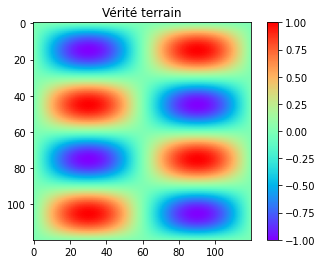

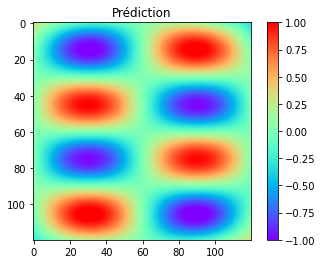

In [11]:
u_pred = [a for a,b in predictions]
exact = [b for a,b in predictions]
u_pred = torch.cat(u_pred).reshape((test.num_test_x,test.num_test_y))
exact = torch.cat(exact).reshape((test.num_test_x,test.num_test_y))

plt.imshow(exact,vmin=-1,vmax=1, cmap='rainbow')
plt.colorbar()
plt.title('Vérité terrain')
plt.show()

plt.imshow(u_pred,vmin=-1,vmax=1, cmap='rainbow')
plt.colorbar()
plt.title('Prédiction')
plt.show()

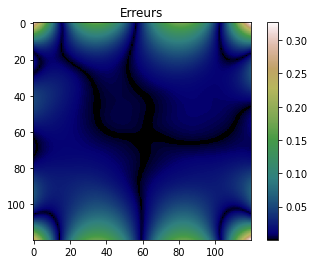

In [12]:
error = np.abs(exact - u_pred)

plt.imshow(error, cmap='gist_earth')
plt.colorbar()
plt.title('Erreurs')
plt.show()

# PINN avec NVIDIA Modulus

En utilisant NVIDA Modulus, coder une solution pour résoudre l'équation de Helmholtz non homogène vu dans ce TP avec un PINN.